<a href="https://colab.research.google.com/github/skywalker0803r/works/blob/master/%E8%BC%95%E6%B2%B9%E6%A1%88%E5%AD%90_sample_weight_C7A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import warnings 
warnings.simplefilter('ignore')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load data

In [2]:
import pandas as pd
#讀取
train = pd.read_csv('/content/drive/My Drive/台塑輕油案子/data/train_4521.csv',index_col=0).reset_index(drop=True)
test_170 = pd.read_csv('/content/drive/My Drive/台塑輕油案子/data/test_170.csv',index_col=0).reset_index(drop=True)
test_250 = pd.read_csv('/content/drive/My Drive/台塑輕油案子/data/test_250.csv',index_col=0).reset_index(drop=True)
#切割資料
test_200 = test_250.loc[ test_250.index % 5 != 0 ,:]#200筆
test_50 = test_250.loc[ test_250.index % 5 == 0 ,:]#50筆
train = train.append(test_200)#加入200筆=4721筆
#重整索引
train = train.reset_index(drop=True)
test_200 = test_200.reset_index(drop=True)
test_50 = test_50.reset_index(drop=True)
#打印
print('train',train.shape)
print('test_170',test_170.shape)
print('test_50',test_50.shape)

train (4721, 27)
test_170 (170, 27)
test_50 (50, 27)


In [3]:
train.head()

,T10,T50,T90,N+A,C5NP,C5IP,C5N,C6NP,C6IP,C6N,C6A,C7NP,C7IP,C7N,C7A,C8NP,C8IP,C8N,C8A,C9NP,C9IP,C9N,C9A,C10NP,C10IP,C10N,C10A
0,100.5,119.2,146.5,31.978,0.272,0.132,0.059,5.293,2.570,2.819,0.494,10.395,8.070,6.411,2.917,9.138,9.649,4.810,5.373,6.405,9.759,4.590,3.661,0.875,5.257,0.525,0.319
1,99.6,117.9,145.5,31.568,0.297,0.151,0.062,5.089,2.531,2.804,0.499,10.074,7.958,6.395,2.894,8.970,9.548,4.753,5.443,6.324,9.899,4.301,2.995,0.881,5.591,1.119,0.303
2,100.0,118.8,145.6,31.344,0.262,0.126,0.061,5.107,2.571,2.771,0.492,10.069,7.913,6.378,2.890,9.006,9.591,4.778,5.468,6.360,9.983,4.274,2.979,0.865,5.641,0.964,0.289
3,100.4,118.6,142.9,31.453,0.224,0.105,0.060,4.894,2.497,2.650,0.469,10.015,7.685,6.376,2.866,9.133,9.708,4.889,5.510,6.444,10.182,4.420,2.964,0.830,5.637,0.968,0.281
4,100.4,118.1,142.2,32.190,0.243,0.117,0.061,4.946,2.503,2.695,0.477,10.053,7.765,6.394,2.877,9.101,9.676,4.855,5.500,6.416,10.115,4.347,3.725,0.835,4.823,0.969,0.290


# def features y_name

In [0]:
features = ['T10','T50','T90','N+A']
y_columns = train.columns.tolist()[4:]
y_name = 'C7A'

# features scaler

In [0]:
from sklearn.preprocessing import StandardScaler
#fit
scaler = StandardScaler().fit(train[features])
#轉換
train[features] = scaler.transform(train[features])
test_170[features] = scaler.transform(test_170[features])
test_50[features] = scaler.transform(test_50[features])

# corr

In [6]:
train[features+[y_name]].corr()

,T10,T50,T90,N+A,C7A
T10,1.000000,0.895238,0.222087,-0.262210,-0.090102
T50,0.895238,1.000000,0.533778,-0.371996,-0.235107
T90,0.222087,0.533778,1.000000,-0.217989,-0.280919
N+A,-0.262210,-0.371996,-0.217989,1.000000,0.458878
C7A,-0.090102,-0.235107,-0.280919,0.458878,1.000000


# features selected

In [0]:
features = ['T10']

# 計算sample weight

In [0]:
import numpy as np
#計算兩個資料點的距離
def count_distance(x1,x2):
  return sum((np.array(x1) - np.array(x2))**2)**(0.5)
#字典根據values排序
def sort_by_value(dict1):
  return sorted(dict1.items(), key=lambda d: d[1],reverse=False)
#給定一個x1找到在x2s上與其距離最短的資料
def find_min_distance_data(x1,x2s):
  x1 = np.array(x1)
  x2s = np.array(x2s)
  d = {}
  for ind,x2 in enumerate(x2s):
    d[ind] = count_distance(x1,x2)
  return sort_by_value(d)

In [9]:
#測試
x1 = test_50.loc[0,features+[y_name]]
x2s = train.loc[:,features+[y_name]]
#看前五個
res = find_min_distance_data(x1,x2s)[:5]
distance_map = dict(res)
distance_map

{636: 0.11642646820356217,
 2362: 0.14825237865059357,
 2515: 0.12638754270599764,
 2520: 0.13152360477696548,
 2581: 0.0545510672773497}

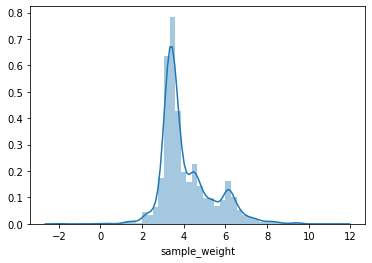

,sample_weight
0,3.630033
1,3.683152
2,3.630630
3,3.539534
4,3.561030


In [10]:
from tqdm import tqdm_notebook as tqdm
import seaborn as sns
from math import log
import matplotlib.pyplot as plt
#樣本權重初始化為0.1
train['sample_weight'] = 0.1
#考慮鄰居數
n = 3
#對test50遍歷,計算與train sample的距離
for row in tqdm(test_50.index):
  distance_map = dict(find_min_distance_data(test_50.loc[row,features+[y_name]],train.loc[:,features+[y_name]]))
  train['sample_weight'] += (1/train.index.map(distance_map))**2
train['sample_weight'] = train['sample_weight'].apply(log)
sns.distplot(train['sample_weight']);plt.show()
train[['sample_weight']].head(5)

# 相似性分類(相似or不相似)

In [0]:
def is_like(S):
  if S>=train['sample_weight'].median():
    return True
  if S<train['sample_weight'].median():
    return False
train['like'] = train['sample_weight'].apply(is_like)

# plot

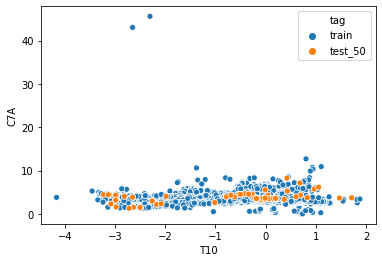

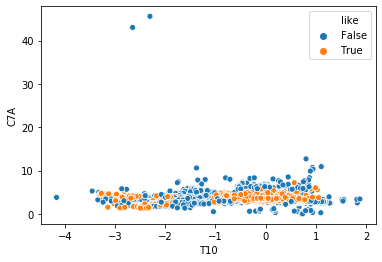

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
train['tag'] = 'train'
test_50['tag'] = 'test_50'
for col in features:
  sns.scatterplot(x = col,y = y_name ,data = train.append(test_50) ,hue='tag')
  plt.show()
  sns.scatterplot(x = col,y = y_name ,data = train ,hue='like')
  plt.show()

# metric

In [0]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score,max_error
import numpy as np
from math import sqrt
def metric(y_t,y_p,name):
  res = {'R2':np.max((r2_score(y_t,y_p),0)),
         'RMSE':sqrt(mean_squared_error(y_t,y_p)),
         'mean_absolute_error %':mean_absolute_error(y_t,y_p)/np.mean(y_t),
         'max_error':max_error(y_t,y_p)}
  return pd.DataFrame(res,index=[name])

In [0]:
def pred_plot(df,by_col,name):
  df = df.sort_values(by = by_col)
  plt.plot(df[by_col],df['y_pred'],label= name+'_pred',color='red')
  plt.scatter(df[by_col],df[y_name],label= name+'_point')
  plt.xlabel(by_col)
  plt.ylabel(y_name)
  plt.legend()

In [0]:
def look_performance(model,by_col,train,test_170,test_50):
  train['y_pred'] = model.predict(train[features])
  test_170['y_pred'] = model.predict(test_170[features])
  test_50['y_pred'] = model.predict(test_50[features])
  fig = plt.figure(figsize=(10,5))
  pred_plot(train,by_col,name='train')
  pred_plot(test_170,by_col,name='test170')
  pred_plot(test_50,by_col,'test_50')
  plt.show()
  return metric(train[y_name],train['y_pred'],name='train').append(
          metric(test_170[y_name],test_170['y_pred'],name='test170')).append(
            metric(test_50[y_name],test_50['y_pred'],name='test50'))

# 萃取特徵

In [0]:
from sklearn.manifold import isomap
iso_col = ['T10','T50','T90','N+A']
iso = isomap.Isomap(n_components=1).fit(train[iso_col])
train['F1'] = iso.transform(train[iso_col])
test_200['F1'] = iso.transform(test_200[iso_col])
test_170['F1'] = iso.transform(test_170[iso_col])
test_50['F1'] = iso.transform(test_50[iso_col])

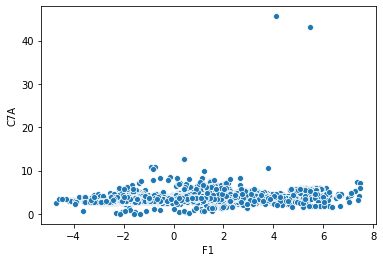

,F1,C7A
F1,1.000000,0.283894
C7A,0.283894,1.000000


In [17]:
sns.scatterplot(x='F1',y=y_name,data=train)
plt.show()
train.corr().loc[['F1',y_name],['F1',y_name]]

# 全部資料加權訓練

In [0]:
by_col = 'F1'
features = ['T10','T50','T90','N+A']

C7A
資料筆數: (4721, 31) (170, 28) (50, 29)


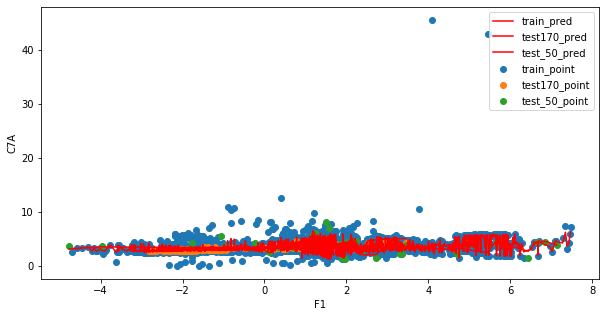

,R2,RMSE,mean_absolute_error %,max_error
train,0.303520,1.008469,0.080851,41.273510
test170,0.697116,0.255757,0.049580,0.972649
test50,0.506633,0.907772,0.152006,3.611233


In [19]:
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression

print(y_name)
print('資料筆數:',train.shape,test_170.shape,test_50.shape)
model_weights = SVR()
model_weights.fit(train[features],train[y_name],sample_weight = train['sample_weight'].values)
look_performance(model_weights,by_col,train,test_170,test_50)

# 只拿相似資料訓練

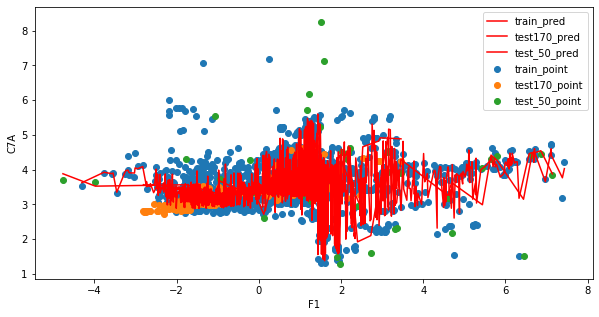

,R2,RMSE,mean_absolute_error %,max_error
train,0.622134,0.365849,0.062151,3.750346
test170,0.191250,0.417923,0.101036,1.008867
test50,0.446479,0.961522,0.152866,3.923742


In [20]:
from sklearn.svm import SVR
from lightgbm import LGBMRegressor

model_like = SVR()
sub_train = train.loc[train['like']==True]
X = sub_train[features];y = sub_train[y_name]
model_like.fit(X,y)
look_performance(model_like,by_col,sub_train,test_170,test_50)

# 只拿200筆fit

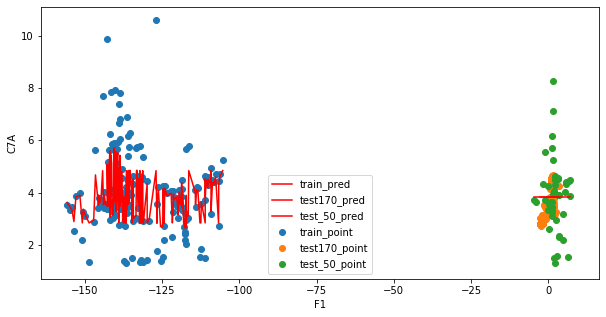

,R2,RMSE,mean_absolute_error %,max_error
train,0.630924,0.863558,0.104905,5.752245
test170,0.000000,0.704745,0.192936,1.105591
test50,0.000000,1.292436,0.234450,4.416419


In [21]:
model_200 = SVR()
model_200.fit(test_200[features],test_200[y_name])
look_performance(model_200,by_col,test_200,test_170,test_50)

# 用4521筆+200筆 fit

C7A
資料筆數: (4721, 32) (170, 29) (50, 30)


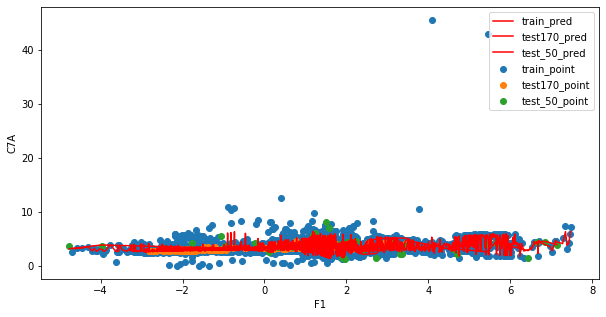

,R2,RMSE,mean_absolute_error %,max_error
train,0.342252,0.980027,0.082489,40.220064
test170,0.657687,0.271894,0.051981,1.029166
test50,0.494812,0.918583,0.162202,3.602231


In [22]:
print(y_name)
print('資料筆數:',train.shape,test_170.shape,test_50.shape)
model = SVR().fit(train[features],train[y_name])
look_performance(model,by_col,train,test_170,test_50)

# def tag outliers

In [0]:
def tag_outliers(df,threshold):
  loss = (df[y_name] - df['y_pred'])**2
  print('loss avg:',np.mean(loss))
  df['out'] = False
  df.loc[loss>threshold,'out'] = True
  return df

# count loss

In [24]:
train_loss = ((train['y_pred']-train[y_name])**2).apply(log)
train_loss = train_loss / np.mean(train_loss)
th1 = np.mean(train_loss) + 2 * train_loss.std()
test_170_loss = ((test_170['y_pred'] - test_170[y_name])**2).apply(log)
test_170_loss = test_170_loss / np.mean(test_170_loss)
th2 = np.mean(test_170_loss) + 2 * test_170_loss.std()
test_50_loss = ((test_50['y_pred'] - test_50[y_name])**2).apply(log)
test_50_loss = test_50_loss / np.mean(test_50_loss)
th3 = np.mean(test_50_loss) + 2 * test_50_loss.std()
print(th1,th2,th3)

2.300441720852521 2.0292654269649413 4.100649340400076


# loss kdeplot

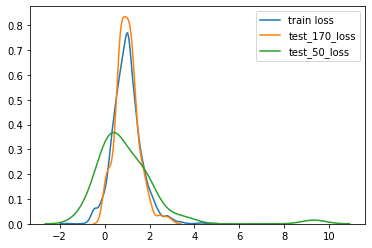

In [25]:
sns.kdeplot(train_loss,label='train loss')
sns.kdeplot(test_170_loss,label='test_170_loss')
sns.kdeplot(test_50_loss,label='test_50_loss')
plt.legend()
plt.show()

# tag loss

In [26]:
train = tag_outliers(train,th1)
test_170 = tag_outliers(test_170,th2)
test_50 = tag_outliers(test_50,th3)

loss avg: 0.960452721791376
loss avg: 0.07392647220382044
loss avg: 0.8437948601243916


# del outliers

In [0]:
train = train[train.out==False]
test_170 = test_170[test_170.out==False]
test_50 = test_50[test_50.out==False]

# after del out metric

C7A
資料筆數: (4591, 33) (170, 30) (47, 31)


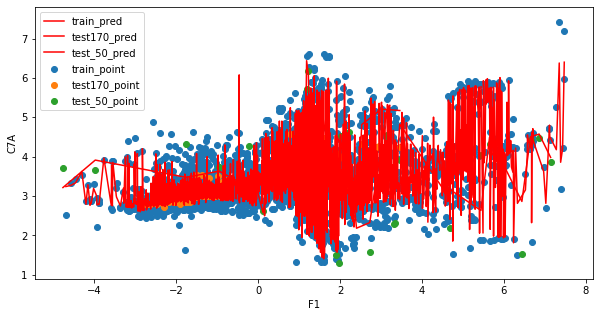

,R2,RMSE,mean_absolute_error %,max_error
train,0.792280,0.309331,0.058935,1.515083
test170,0.657687,0.271894,0.051981,1.029166
test50,0.615152,0.630868,0.134288,1.401686


In [28]:
print(y_name)
print('資料筆數:',train.shape,test_170.shape,test_50.shape)
look_performance(model,by_col,train,test_170,test_50)